In [22]:
from qokit import parameter_utils
from qokit.qaoa_circuit_labs import (
    get_qaoa_circuit,
    append_cost_operator_circuit,
    append_mixer_operator_circuit)
from qokit.labs import get_gate_optimized_terms_greedy
import math
import qiskit_aer.noise as noise
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    Aer, 
    transpile
)

def split_circuit_by_barrier(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('barrier'):
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    # for circuit_with_prelude in circuits_with_prelude:
    return [QuantumCircuit.from_qasm_str('\n'.join(circ)) for circ in circuits_with_prelude]

def composeQAOACirc(nDataQ, nAncilQ, aCRegs, lCheckCirc, layers, rCheckCirc):
    '''
    nQubits: number of data qubits
    nAncilQ: number of ancilla qubits
    aCRegs: ancilla classical registers
    lCheckCirc: left Pauli checks circ
    layers: pairs of cost and mixer circs
    rCheckCirc: right Pauli checks circ
    '''
    compCirc=QuantumCircuit(nDataQ+nAncilQ)
    # first, apply a layer of Hadamards
    compCirc.h(list(range(nDataQ)))
    for idx, pair in enumerate(layers):
        compCirc=compCirc.compose(lCheckCirc)
        compCirc.barrier()
        compCirc=compCirc.compose(pair[0])
        compCirc.barrier()
        compCirc=compCirc.compose(rCheckCirc)
        compCirc.barrier()
        compCirc=compCirc.compose(pair[1])
        compCirc.measure(list(range(nDataQ, nDataQ+nAncilQ)), aCRegs[idx*nAncilQ:(idx+1)*nAncilQ])
        compCirc.reset(list(range(nDataQ, nDataQ+nAncilQ)))
        compCirc.barrier()
    return compCirc

def postSelect(counts, nData, nAncillas):
    '''Post select based on the 0 outcomes of the ancillas'''
    postCounts={k.split(" ")[1]:v for k, v  in counts.items() if k.split(" ")[0]=="0"*nAncillas}
    assert all([len(k)==nData for k in postCounts.keys()])
    return postCounts

def toProbs(dist):
    total=sum([val for val in dist.values()])
    return {k: v/total for k, v in dist.items()}

def get_sso(dist1, dist2):
    '''Returns the square of the statistical overlap. 
    dist1 and dist2 are probability distributions.
    dist1: list
    dits2: list'''
    sum=0
    common_keys=dist1.keys() & dist2.keys()
    # print(f"dist1: {dist1}")
    # print(f"dist2: {dist2}")
    for key in common_keys:
        # print(f"key: {key}")
        # print(f"dist1[key]: {dist1[key]}")
        # print(f"dist2[key]: {dist2[key]}")
        sum+=math.sqrt(dist1[key]*dist2[key])
    return sum**2

def extrapolate2(data1: tuple, data2: tuple, nqubits):
    '''
    Does a linear extrapolation of distributions based on the two data points.
    data1: (dist1, x1)
    data2: (dist2, x2)
    '''
    # determine which data pt is 1 or 2 (smaller or greater on the x-axis).
    if data1[1]<data2[1]:
        dist1, x1= data1
        dist2, x2= data2
    else:
        dist1, x1= data2
        dist2, x2= data1
    print(f"x1: {x1}")
    print(f"dist1: {dist1}")
    print(f"x2: {x2}")
    print(f"dist2: {dist2}")
    # common_keys = dist1.keys() & dist2.keys()
    keys2=dist2.keys()
    # each value in the distribution may have a different slope
    slopes={k:(dist2[k]-dist1.get(k,0))/(x2-x1) for k in keys2}
    print(f"slopes: {slopes}")
    # y-axis intercepts
    yints={k:dist2[k]-slopes[k]*x2 for k in keys2}
    # y=mx + b
    idealDist={k:slopes[k]*2*nqubits+yints[k] for k in keys2}
    # remove negative values
    filteredDist={k:v for k, v in idealDist.items() if v>0}
    tot=sum(filteredDist.values())
    # renormalize
    renormDist={k:v/tot for k,v in filteredDist.items()}
    return renormDist
    

In [23]:
# parameters. N is the number of qubits and p is the number of qaoa layers.
N = 6
p = 12
gamma, beta = parameter_utils.get_best_known_parameters_for_LABS_wrt_overlap_for_p(N, p)
terms = get_gate_optimized_terms_greedy(N) # indices of Pauli Zs
assert len(beta) == len(gamma)
p = len(beta)  # infering number of QAOA steps from the parameters passed
SHOTS=10000

# Error probabilities
prob_1 = 0.00003  # 1-qubit gate
prob_2 = 0.002   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['h', 'x','y','z', 'rz'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx', 'cz', 'rzz'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

noisySim = AerSimulator(noise_model=noise_model,
                       basis_gates=basis_gates)

idealSim = Aer.get_backend('aer_simulator')
print(gamma)
print(beta)

seed: 1316635980
[0.1323402648, 0.1388339634, 0.1453136336, 0.134980811, 0.1831464882, 0.2792842225, 0.1606766925, 0.06970711510000001, 0.1557263753, 0.2626388232, 0.3925005225, 0.6532959351000001]
[-1.8930604821, -1.9364777407, -1.9389363115, -1.8557293664, -1.6969318884, -1.6061105628, -1.6460087718, -1.6701402791, -1.6292685157, -1.4664313482, -1.2403973409, -0.5819295092]


In [24]:
# this is a list of tuples of cost circs and mixer circs for qaoa
layersCircs=[]
for i in range(p):
    qc1 = QuantumCircuit(N)
    append_cost_operator_circuit(qc1, terms, gamma[i])
    qc2 = QuantumCircuit(N)
    append_mixer_operator_circuit(qc2, beta[i])
    layersCircs.append((qc1, qc2))
# print(layersCircs[0][0].qasm())
# print(layersCircs[0][1].qasm())
# # qc.save_statevector()  # type: ignore


In [25]:
# Get raw QAOA circ
rawQc=QuantumCircuit(N)
# first, apply a layer of Hadamards
rawQc.h(range(N))
for pair in layersCircs:
    layer=pair[0].compose(pair[1])
    rawQc.compose(layer, inplace=True)
rawQc.measure_all()
idealQc = transpile(rawQc, idealSim, optimization_level=None)
print(idealQc)

# Get ideal results
idealResult = idealSim.run(idealQc, shots=SHOTS).result()
idealCounts = idealResult.get_counts()
idealDist= toProbs(idealCounts)
print(idealCounts)
print(idealDist)


        ┌───┐                                                              »
   q_0: ┤ H ├──■───────────────────────────────────────────────────────────»
        ├───┤┌─┴─┐                                                         »
   q_1: ┤ H ├┤ X ├─■──────────────────■───────────────────────■────────────»
        ├───┤├───┤ │ZZ(0.52936) ┌───┐ │                       │            »
   q_2: ┤ H ├┤ X ├─■────────────┤ X ├─┼───────────────────────┼────────────»
        ├───┤└─┬─┘              └─┬─┘ │                 ┌───┐ │ZZ(0.52936) »
   q_3: ┤ H ├──■──────────────────■───┼─────────────────┤ X ├─■────────────»
        ├───┤┌───┐                    │ZZ(0.52936) ┌───┐└─┬─┘              »
   q_4: ┤ H ├┤ X ├────────────────────■────────────┤ X ├──■────────────────»
        ├───┤└─┬─┘                                 └─┬─┘                   »
   q_5: ┤ H ├──■─────────────────────────────────────■─────────────────────»
        └───┘                                                              »

Two circuits: all checks controlled on only 1 ancilla. 1 ancilla for each check.

In [26]:
# no checks noisy.
nopcs=transpile(rawQc, noisySim, optimization_level=None)
nopcsResult=noisySim.run(nopcs, shots=SHOTS).result()
nopcsCounts=nopcsResult.get_counts()
nopcsDist=toProbs(nopcsCounts)
nopcssso=get_sso(nopcsDist, idealDist)
print(nopcsDist)
print(nopcssso)

{'010011': 0.0153, '101011': 0.0089, '000010': 0.0135, '110101': 0.0082, '100010': 0.016, '111110': 0.0083, '001011': 0.0874, '000110': 0.0129, '101111': 0.0134, '110001': 0.0089, '111001': 0.0134, '110010': 0.015, '000101': 0.0141, '101110': 0.0142, '100100': 0.0088, '111100': 0.0101, '001101': 0.0136, '111111': 0.007, '001010': 0.0077, '100001': 0.0924, '011001': 0.0065, '000011': 0.0094, '101100': 0.0146, '110100': 0.0928, '011110': 0.0891, '001000': 0.0136, '011111': 0.008, '101010': 0.0051, '000001': 0.0082, '110110': 0.0088, '100110': 0.0059, '111010': 0.0132, '001111': 0.0085, '111011': 0.0118, '001110': 0.0085, '100101': 0.0076, '011000': 0.0136, '100111': 0.014, '010100': 0.0091, '000000': 0.007, '110111': 0.0143, '011101': 0.0168, '010010': 0.01, '001100': 0.0073, '111101': 0.0142, '100011': 0.0097, '010001': 0.0163, '010110': 0.0097, '101101': 0.0095, '110011': 0.0076, '000100': 0.0155, '011010': 0.0084, '010111': 0.0138, '010101': 0.007, '100000': 0.0092, '111000': 0.0088, 

In [27]:
# all checks controlled on only 1 ancilla
A=1 # number of ancillas or number of pairs of checks.
# left checks
dataRegsLpcs1=QuantumRegister(N)
ancillRegsLpcs1=QuantumRegister(A)
# right checks
dataRegsRPcs1=QuantumRegister(N)
ancillRegsRpcs1=QuantumRegister(A)
# classical regs
aCRegspcs1=ClassicalRegister(p*A)
dCRegspcs1=ClassicalRegister(N)
qcLpcs=QuantumCircuit(dataRegsLpcs1, ancillRegsLpcs1, dCRegspcs1, aCRegspcs1)
qcRpcs=QuantumCircuit(dataRegsRPcs1, ancillRegsRpcs1)
qcLpcs.h(ancillRegsLpcs1[0])
# for idx, _ in enumerate(dataRegsLpcs1):
qcLpcs.cz(ancillRegsLpcs1[0], dataRegsLpcs1[0])
qcRpcs.cz(ancillRegsRpcs1[0], dataRegsRPcs1[0])
qcRpcs.h(ancillRegsRpcs1[0])

# Compose the pieces together
compCircpcs=composeQAOACirc(N, A, aCRegspcs1, qcLpcs, layersCircs, qcRpcs)
compCircpcs.measure(list(range(N)), dCRegspcs1)
print(compCircpcs)

# Run noisy simulation
compCircpcs = transpile(compCircpcs, noisySim, optimization_level=None)
resultpcs = noisySim.run(compCircpcs, shots=SHOTS).result()
countspcs = resultpcs.get_counts()
countspcsFinal=postSelect(countspcs, N, A*p)
pcsPostselectRate=sum(countspcsFinal.values())/SHOTS
pcsDist= toProbs(countspcsFinal)
pcssso=get_sso(pcsDist, idealDist)
print(countspcs)
print(countspcsFinal)
print(pcsDist)
print(pcssso)
print(pcsPostselectRate)

       ┌───┐    ░                                                      »
  q_0: ┤ H ├─■──░───■──────────────────■────■──────────────────■────■──»
       ├───┤ │  ░ ┌─┴─┐              ┌─┴─┐┌─┴─┐              ┌─┴─┐┌─┴─┐»
  q_1: ┤ H ├─┼──░─┤ X ├─■────────────┤ X ├┤ X ├─■────────────┤ X ├┤ X ├»
       ├───┤ │  ░ ├───┤ │ZZ(0.52936) ├───┤└───┘ │            └───┘└───┘»
  q_2: ┤ H ├─┼──░─┤ X ├─■────────────┤ X ├──────┼──────────────────────»
       ├───┤ │  ░ └─┬─┘              └─┬─┘      │                 ┌───┐»
  q_3: ┤ H ├─┼──░───■──────────────────■────────┼─────────────────┤ X ├»
       ├───┤ │  ░ ┌───┐                         │ZZ(0.52936) ┌───┐└─┬─┘»
  q_4: ┤ H ├─┼──░─┤ X ├─────────────────────────■────────────┤ X ├──■──»
       ├───┤ │  ░ └─┬─┘                                      └─┬─┘     »
  q_5: ┤ H ├─┼──░───■──────────────────────────────────────────■───────»
       ├───┤ │  ░                                                      »
  q_6: ┤ H ├─■──░──────────────────────────────────

In [28]:
extrapDist=extrapolate2((pcsDist, 1), (nopcsDist, 0), N)
print(get_sso(extrapDist, idealDist))
extrapDist=extrapolate2((nopcsDist, 0), (pcsDist, 1), N)
extrapsso=get_sso(extrapDist, idealDist)
print(extrapsso)

x1: 0
dist1: {'010011': 0.0153, '101011': 0.0089, '000010': 0.0135, '110101': 0.0082, '100010': 0.016, '111110': 0.0083, '001011': 0.0874, '000110': 0.0129, '101111': 0.0134, '110001': 0.0089, '111001': 0.0134, '110010': 0.015, '000101': 0.0141, '101110': 0.0142, '100100': 0.0088, '111100': 0.0101, '001101': 0.0136, '111111': 0.007, '001010': 0.0077, '100001': 0.0924, '011001': 0.0065, '000011': 0.0094, '101100': 0.0146, '110100': 0.0928, '011110': 0.0891, '001000': 0.0136, '011111': 0.008, '101010': 0.0051, '000001': 0.0082, '110110': 0.0088, '100110': 0.0059, '111010': 0.0132, '001111': 0.0085, '111011': 0.0118, '001110': 0.0085, '100101': 0.0076, '011000': 0.0136, '100111': 0.014, '010100': 0.0091, '000000': 0.007, '110111': 0.0143, '011101': 0.0168, '010010': 0.01, '001100': 0.0073, '111101': 0.0142, '100011': 0.0097, '010001': 0.0163, '010110': 0.0097, '101101': 0.0095, '110011': 0.0076, '000100': 0.0155, '011010': 0.0084, '010111': 0.0138, '010101': 0.007, '100000': 0.0092, '1110

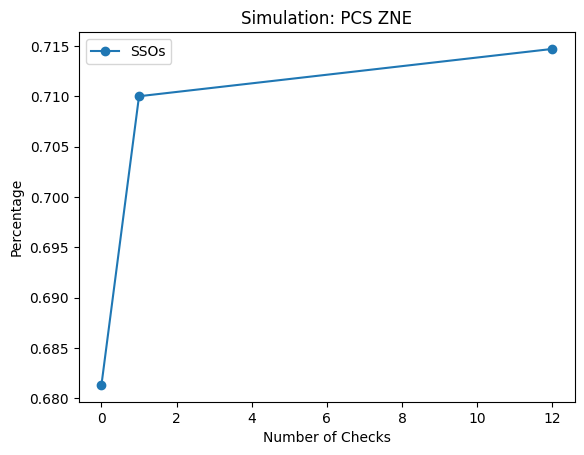

In [29]:
# Linear extrapolation based on the number of pairs of checks.
xpts=[0,1,2*N]
ypts=[nopcssso, pcssso, extrapsso]
plt.plot(xpts, ypts, label="SSOs", marker='o')
plt.ylabel('Percentage')
plt.xlabel("Number of Checks")
plt.title("Simulation: PCS ZNE")
plt.legend()
plt.show()

In [30]:
# Linear extrapolation. x-axis post selection rate.
extrapDist2=extrapolate2((pcsDist, pcsPostselectRate), (nopcsDist, 1), N)
print(get_sso(extrapDist, idealDist))
extrapsso2=get_sso(extrapDist, idealDist)
print(extrapsso2)

x1: 0.9079
dist1: {'011110': 0.09505452142306421, '001110': 0.009692697433638067, '111011': 0.017402797664941072, '100101': 0.008921687410507766, '100011': 0.00903183169952638, '111101': 0.013107170393215111, '001100': 0.005947791607005177, '000011': 0.008370965965414694, '101100': 0.014539046150457098, '110100': 0.09769798435951096, '100000': 0.005727503028967948, '001000': 0.014649190439475714, '001010': 0.007269523075228549, '111111': 0.007159378786209935, '100001': 0.09670668575834343, '000001': 0.007820244520321621, '101010': 0.0066086573411168635, '110110': 0.009141975988544994, '100010': 0.016411499063773545, '111110': 0.007930388809340235, '001011': 0.0949443771340456, '101110': 0.01652164335279216, '110010': 0.013988324705364028, '000101': 0.015530344751624629, '101011': 0.00627822447406102, '110101': 0.0064985130520982485, '000010': 0.012446304659103425, '111100': 0.006828945919154092, '100100': 0.007379667364247164, '100111': 0.01508976759555017, '011101': 0.0129970261041964

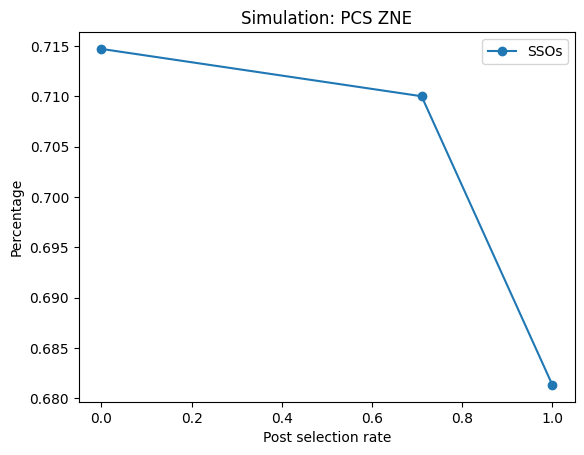

In [31]:
# Linear extrapolation. x-axis post selection rate.
xpts=[1,pcssso,0]
ypts=[nopcssso, pcssso, extrapsso2]
plt.plot(xpts, ypts, label="SSOs", marker='o')
plt.ylabel('Percentage')
plt.xlabel("Post selection rate")
plt.title("Simulation: PCS ZNE")
plt.legend()
plt.show()